# Supervised Learning Models  
The goal of this notebook is to create a machine learning pipeline that test multiple base forms (no hyper parameter tuning) of supervised machine learning techniques. This will allow us to determine the best baseline model to then tune in order to maximize performance. We want to set this up in a form that allows us to apply it to many different subsets of our feature space to see what works best and reduce model complexity while maintaining forecasting of out-of-sample data.

## Import Libraries
There are going to be a lot of different baseline models that we need to import here. The goal will be to produce a pipeline that runs the dataset through all of these models and outputs a box-whisker plot showing the RMSE.

In [ ]:
# Data Manipulation libraries
import numpy as np
import pandas as pd

# Sci-Kit Learn Processing and Evaluating
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer


# Supervised Learning Models  
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso  
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor  
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Let's set our Random State here as well
random_state = 9

## Load Data Files
Now we need to load both the X_data files and the y_data files for comparisons.

In [2]:
root_path = '../../datasets/'
X_train_file = 'X_train_filled_KPIs_QoQ_PCA.csv'
y_train_file = 'y_train.csv'
X = pd.read_csv(root_path+X_train_file)
y = pd.read_csv(root_path+y_train_file)
print(X.shape, y.shape)
print(X.tail(),y.tail())


(1910, 326) (1974, 19)
     Ticker                               Name                  Sector  \
1905    CNS                 COHEN & STEERS INC              Financials   
1906    FBP                      FIRST BANCORP              Financials   
1907   RDDT                 REDDIT INC CLASS A           Communication   
1908    AGM  FEDERAL AGRICULTURAL MORTGAGE NON              Financials   
1909    EAT          BRINKER INTERNATIONAL INC  Consumer Discretionary   

      CapitalExpenditure_2024Q2  CapitalExpenditure_2024Q3  \
1905                 -4239000.0                 -1408000.0   
1906                 -3264000.0                 -2547000.0   
1907                 -1202000.0                 -1353000.0   
1908                 -3568000.0                   -66000.0   
1909                -58000000.0                -56500000.0   

      CapitalExpenditure_2024Q4  CapitalExpenditure_2025Q1  \
1905                 -1678000.0                 -1075000.0   
1906                 -3407000.0    

Let's put in a small section where we can filter out the Mega and Nano caps before changing the y-variables.

In [3]:
print(X['Market Cap'].unique())
print(X.shape)
X = X[(X['Market Cap'] != 'Mega-Cap') & (X['Market Cap'] != 'Micro-Cap')]
print(X.shape)
print(X['Market Cap'].unique())

['Small-Cap' 'Micro-Cap' 'Mid-Cap' 'Large-Cap' 'Mega-Cap']
(1910, 326)
(1400, 326)
['Small-Cap' 'Mid-Cap' 'Large-Cap']


Alright, the first thing that I notice is that we have different sizes of files. That means we dropped rows in our X split but didn't drop them in our y. So let's address this first.

In [4]:
in_train = set(X['Ticker'])
y = y[y['Ticker'].isin(in_train)].copy()
print(len(in_train))
print(y.shape)
#print(X.tail(),y.tail())

1400
(1400, 19)


### Set up our dependent variables (y1 and y2)
Now, Let's get our two different y variables that we want to compare to. y1 will be total Revenue, y2 will be net income.

In [5]:
# Let's pull out the data we want to predict
y1_rev = y['Revenue_2025Q2']
y2_ear = y['NetIncome_2025Q2']
y3_rev_rat = (y['Revenue_2025Q2'] - X['Revenue_2025Q1'])/X['Revenue_2025Q1']
print(y1_rev.shape,y2_ear.shape, y3_rev_rat.shape)
print(y1_rev.isna().sum())
print(y2_ear.isna().sum())
print(y3_rev_rat.isna().sum())
print(y3_rev_rat[:5])

(1400,) (1400,) (1821,)
224
224
1000
0         NaN
3    0.078966
4         NaN
5    5.523079
6         NaN
dtype: float64


So, it turns out that we have a lot of missing values that we are trying to predict here. So we obviously need to remove them.


In [6]:
y = y[['Ticker','Revenue_2025Q2','NetIncome_2025Q2']]
print(y.shape)
y.dropna(inplace=True)
print(y.shape)
in_dependent = set(y['Ticker'])
X = X[X['Ticker'].isin(in_dependent)].copy()
print(X.shape)

(1400, 3)
(1176, 3)
(1176, 326)


Now, we can reassing the y1_rev and the y2_ear.

In [7]:
y1_rev = y['Revenue_2025Q2']
y2_ear = y['NetIncome_2025Q2']
y3_rev_rat = (y['Revenue_2025Q2'] - X['Revenue_2025Q1'])/X['Revenue_2025Q1']
y4_margin =y['NetIncome_2025Q2']/y['Revenue_2025Q2']
print(y1_rev.isna().sum())
print(y2_ear.isna().sum())
print(y3_rev_rat.isna().sum())
print(y4_margin.isna().sum())


0
0
958
0


Great, now similar to our unsupervised notebook. We need to do a little data cleaning and manipulation on our X here so that we have useable X and y data. Let's start by dropping the unique columns that will not help us in identifying trends (Ticker, Name)

## Dataset Separation
Alright, I think one of the first things we should do is identify three different datasets that we want to work with.  
1. Full Dataset (minus columns like Ticker)  
2. Raw Data Dataset (What would it look like if we just used the raw financial data) 
4. KPIs and PCA Dataset (Engineered data and data reduction dataset; this may end up being 2) 
3. Engineered Dataset (Do we get better structure when we look at just the engineered features)

We can easily just split these into subdatasets if we pull out the relevant columns. So let's look at all of the columns first so that we can start creating the proper datasets.

In [8]:
complete_dataset = X.copy()
columns = complete_dataset.columns.tolist()
for column in sorted(columns):
    print(column)

CapitalExpenditure_2024Q2
CapitalExpenditure_2024Q3
CapitalExpenditure_2024Q4
CapitalExpenditure_2025Q1
CapitalExpenditure_QoQ_24Q2_24Q3
CapitalExpenditure_QoQ_24Q3_24Q4
CapitalExpenditure_QoQ_24Q4_25Q1
CapitalExpenditure_QoQ_Rate
CapitalExpenditure_Rate
CashAndSTInvestments_2024Q2
CashAndSTInvestments_2024Q3
CashAndSTInvestments_2024Q4
CashAndSTInvestments_2025Q1
CashAndSTInvestments_QoQ_24Q2_24Q3
CashAndSTInvestments_QoQ_24Q3_24Q4
CashAndSTInvestments_QoQ_24Q4_25Q1
CashAndSTInvestments_QoQ_Rate
CashAndSTInvestments_Rate
CashFromOps_2024Q2
CashFromOps_2024Q3
CashFromOps_2024Q4
CashFromOps_2025Q1
CashFromOps_QoQ_24Q2_24Q3
CashFromOps_QoQ_24Q3_24Q4
CashFromOps_QoQ_24Q4_25Q1
CashFromOps_QoQ_Rate
CashFromOps_Rate
Cluster
CostOfRevenue_2024Q2
CostOfRevenue_2024Q3
CostOfRevenue_2024Q4
CostOfRevenue_2025Q1
CostOfRevenue_QoQ_24Q2_24Q3
CostOfRevenue_QoQ_24Q3_24Q4
CostOfRevenue_QoQ_24Q4_25Q1
CostOfRevenue_QoQ_Rate
CostOfRevenue_Rate
CurrentAssets_2024Q2
CurrentAssets_2024Q3
CurrentAssets_2024Q4

Alright, let's start by identifying which columns to drop because they are unnecessary for the unsupervised learning part. This should be relatively few columns.
- Ticker
- Name  


In [9]:
complete_dataset = complete_dataset.drop(columns=['Ticker','Name'])
print(complete_dataset.shape)

(1176, 324)


Great, now, we can loop through all of the columns and we will pull out all of the feature engineered data if it contains 'KPI', 'QoQ', or 'Rate' in the title. We can then investigate these columns to make sure they make sense.

In [10]:
raw_columns = []
engineered_columns = []
pca_columns = []
revenue_columns = []
for column in complete_dataset.columns:
    if ('KPI' not in column) and ('QoQ' not in column) and ('Rate' not in column) and ('PCA' not in column) and ('Cluster' not in column):
        raw_columns.append(column)
    else:
        engineered_columns.append(column)
for column in complete_dataset.columns:
    if ('PCA' not in column) and ('Cluster' not in column):
        continue
    else:
        pca_columns.append(column)
for column in complete_dataset.columns:
    if ('Revenue' in column) and ('CostOf' not in column):
        revenue_columns.append(column)
print(f'Raw Columns: {len(raw_columns)}')
print(f'Engineered Columns: {len(engineered_columns)}')
print(f'PCA Columns {len(pca_columns)}')
print(f'Revenue Columns {len(revenue_columns)}')

Raw Columns: 102
Engineered Columns: 222
PCA Columns 61
Revenue Columns 9


In [11]:
for column in engineered_columns:
    print(column)

InterestRate_2024Q1
InterestRate_2024Q2
InterestRate_2024Q3
InterestRate_2024Q4
InterestRate_2025Q1
KPI_GrossProfitMargin_2024Q2
KPI_GrossProfitMargin_2024Q3
KPI_GrossProfitMargin_2024Q4
KPI_GrossProfitMargin_2025Q1
KPI_NetProfitMargin_2024Q2
KPI_NetProfitMargin_2024Q3
KPI_NetProfitMargin_2024Q4
KPI_NetProfitMargin_2025Q1
KPI_CurrentRatio_2024Q2
KPI_CurrentRatio_2024Q3
KPI_CurrentRatio_2024Q4
KPI_CurrentRatio_2025Q1
KPI_Leverage_2024Q2
KPI_Leverage_2024Q3
KPI_Leverage_2024Q4
KPI_Leverage_2025Q1
KPI_DebtToEquityRatio_2024Q2
KPI_DebtToEquityRatio_2024Q3
KPI_DebtToEquityRatio_2024Q4
KPI_DebtToEquityRatio_2025Q1
KPI_TotalAssetTurnover_2024Q3
KPI_TotalAssetTurnover_2024Q4
KPI_TotalAssetTurnover_2025Q1
KPI_ReturnOnEquity_2024Q3
KPI_ReturnOnEquity_2024Q4
KPI_ReturnOnEquity_2025Q1
KPI_ReturnOnAssets_2024Q3
KPI_ReturnOnAssets_2024Q4
KPI_ReturnOnAssets_2025Q1
TotalEquity_QoQ_24Q2_24Q3
TotalEquity_QoQ_24Q3_24Q4
TotalEquity_QoQ_24Q4_25Q1
TotalLiabilities_QoQ_24Q2_24Q3
TotalLiabilities_QoQ_24Q3_24Q

Now, there are going to be some of the raw columns that we want to add back to the engineered columns as they can be very important components to the company, so let's list these here.
- Sector  
- Exchange
- Location  
- Market Cap
- Market Value

So let's append those

In [12]:
add_back = ['Sector','Exchange','Location','Market Value','Market Cap']
engineered_columns = engineered_columns + add_back
print(f'Engineered Columns after adding back important raw columns: {len(engineered_columns)}')

Engineered Columns after adding back important raw columns: 227


Alright, now we can build out all of our feature dataframes to test them all.

In [13]:
raw_data = complete_dataset[raw_columns]
eng_data = complete_dataset[engineered_columns]
tot_data = complete_dataset.copy()
#kpi_data = place holder for the KPI data
pca_data = complete_dataset[pca_columns]
rev_data = complete_dataset[revenue_columns + add_back]

print(f'Full Dataset Shape: {tot_data.shape}')
print(f'Raw Data Shape: {raw_data.shape}')
print(f'Engineered Data Shape: {eng_data.shape}')
#print(f'KPI Data shape: {kpi_data.shape}')
print(f'PCA reduced Data Shape: {pca_data.shape}')
print(f'Rev reduced Data Shape: {rev_data.shape}')


Full Dataset Shape: (1176, 324)
Raw Data Shape: (1176, 102)
Engineered Data Shape: (1176, 227)
PCA reduced Data Shape: (1176, 61)
Rev reduced Data Shape: (1176, 14)


## Fundamental Data
Now that we have all of our data setup, we need to work on the preprocessing steps in order to have machine readable information being fed into our supervised model. 

### Scaler Set

In [14]:
# Let's set our scaler here
scaler = QuantileTransformer()
#scaler = StandardScaler()

## Aside
I wanted to see whether only using the revenue data was better at predicting the revenue than the full dataset so I came back up to the top of my notebook to run this section

In [ ]:
## Lets see how we do with just the rev data.
#X_rev = rev_data.copy()
## columns
#cat_cols = ['Sector', 'Exchange', 'Market Cap'] 
#num_cols = [c for c in X_rev.columns if c not in cat_cols]
#
## models (set seeds where applicable)
#models = [
#    ('DUMMY', DummyRegressor(strategy='median')),
#    ('LR', LinearRegression()),
#    ('RIDGE', Ridge()),
#    ('LASSO', Lasso()),
#    ('EN', ElasticNet()),
#    ('KNN', KNeighborsRegressor()),
#    ('DT', DecisionTreeRegressor(random_state=random_state)),
#    ('SVR', SVR()),
#    ('RFR', RandomForestRegressor(random_state=random_state)),
#    ('ETR', ExtraTreesRegressor(random_state=random_state)),
#    ('ABR', AdaBoostRegressor(random_state=random_state)),
#    ('GBR', GradientBoostingRegressor(random_state=random_state)),
#    ('MLP', MLPRegressor(random_state=random_state))
#]
#
## preprocessing
#preproc = ColumnTransformer([
#    ('num', Pipeline([
#        ('scale', scaler)
#    ]), num_cols),
#    ('cat', Pipeline([
#        ('ohe', OneHotEncoder(handle_unknown='ignore'))
#    ]), cat_cols),
#])
#
#cv = KFold(n_splits=5, shuffle = True, random_state=random_state)
#scorer = 'neg_root_mean_squared_error'  # RMSE as negative; flip sign after
#
#names, kfold_results_rev, kfold_results_ear, kfold_results_rat = [], [], [], []
#
#for name, model in models:
#    pipe = Pipeline([('prep', preproc), ('model', model)])
#    rmse_rev = -cross_val_score(pipe, X_rev, y1_rev, cv=cv, scoring=scorer, n_jobs=-1)
#    rmse_ear = -cross_val_score(pipe, X_rev, y2_ear, cv=cv, scoring=scorer, n_jobs=-1)
#    
#    names.append(name)
#    kfold_results_rev.append(rmse_rev)
#    kfold_results_ear.append(rmse_ear)
#    
#
## optional: summary
#summary = pd.DataFrame({
#    'model': names,
#    'rev_rmse_mean': [r.mean() for r in kfold_results_rev],
#    'rev_rmse_std':  [r.std()  for r in kfold_results_rev],
#    'ear_rmse_mean': [r.mean() for r in kfold_results_ear],
#    'ear_rmse_std':  [r.std()  for r in kfold_results_ear],
#}).sort_values('rev_rmse_mean')
#summary

,model,rev_rmse_mean,rev_rmse_std,ear_rmse_mean,ear_rmse_std
6,DT,1.610038e+09,1.091248e+09,8.342204e+08,1.102847e+08
8,RFR,1.885333e+09,1.875072e+09,5.190496e+08,1.270698e+08
9,ETR,1.940979e+09,2.031995e+09,5.566201e+08,1.147645e+08
11,GBR,2.076271e+09,1.914287e+09,5.425511e+08,1.484478e+08
10,ABR,2.240572e+09,1.121496e+09,5.493901e+08,1.337903e+08
2,RIDGE,7.404113e+09,2.502342e+09,6.504469e+08,1.511972e+08
3,LASSO,7.421466e+09,2.505783e+09,6.518888e+08,1.531563e+08
1,LR,7.421466e+09,2.505783e+09,6.518888e+08,1.531563e+08
4,EN,7.566079e+09,3.037239e+09,6.944440e+08,1.752729e+08
5,KNN,7.758919e+09,1.875463e+09,6.741500e+08,1.446899e+08


In [16]:
# Let's try a better looking chart in altair
df_rev = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rev)]),
    "rmse":  np.concatenate(kfold_results_rev)
})

df_rev['rmse'] = df_rev['rmse']/1_000_000

rev_chart = alt.Chart(df_rev).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Revenue'
)

rev_chart

alt.Chart(...)

## Continue with original notebook
Here we will resume to our original order of testing models

In [ ]:
# Lets attempt this first with the raw data
X_raw = raw_data.copy()
# columns
cat_cols = ['Sector', 'Exchange', 'Market Cap'] 
num_cols = [c for c in X_raw.columns if c not in cat_cols]

# models (set seeds where applicable)
models = [
    ('DUMMY', DummyRegressor(strategy='median')),
    ('LR', LinearRegression()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('DT', DecisionTreeRegressor(random_state=random_state)),
    ('SVR', SVR()),
    ('RFR', RandomForestRegressor(random_state=random_state)),
    ('ETR', ExtraTreesRegressor(random_state=random_state)),
    ('ABR', AdaBoostRegressor(random_state=random_state)),
    ('GBR', GradientBoostingRegressor(random_state=random_state)),
    ('MLP', MLPRegressor(random_state=random_state))
]

# preprocessing
preproc = ColumnTransformer([
    ('num', Pipeline([
        ('scale', scaler)
    ]), num_cols),
    ('cat', Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols),
])

cv = KFold(n_splits=5, shuffle = True, random_state=random_state)
scorer = 'neg_root_mean_squared_error'  # RMSE as negative; flip sign after

names, kfold_results_rev, kfold_results_ear, kfold_results_rat, kfold_results_marg= [], [], [], [], []

for name, model in models:
    pipe = Pipeline([('prep', preproc), ('model', model)])
    rmse_rev = -cross_val_score(pipe, X_raw, y1_rev, cv=cv, scoring=scorer, n_jobs=-1)
    rmse_ear = -cross_val_score(pipe, X_raw, y2_ear, cv=cv, scoring=scorer, n_jobs=-1)
    
    rmse_marg = -cross_val_score(pipe, X_raw, y4_margin, cv=cv, scoring=scorer, n_jobs=-1)
    names.append(name)
    kfold_results_rev.append(rmse_rev)
    kfold_results_ear.append(rmse_ear)
    
    kfold_results_marg.append(rmse_marg)

# optional: summary
summary = pd.DataFrame({
    'model': names,
    'rev_rmse_mean': [r.mean() for r in kfold_results_rev],
    'rev_rmse_std':  [r.std()  for r in kfold_results_rev],
    'ear_rmse_mean': [r.mean() for r in kfold_results_ear],
    'ear_rmse_std':  [r.std()  for r in kfold_results_ear],
}).sort_values('rev_rmse_mean')
summary

,model,rev_rmse_mean,rev_rmse_std,ear_rmse_mean,ear_rmse_std
9,ETR,1.601146e+09,2.503516e+09,3.866253e+08,2.238190e+08
11,GBR,1.704311e+09,2.608168e+09,3.927196e+08,2.431379e+08
8,RFR,1.748918e+09,2.363200e+09,3.883798e+08,2.361274e+08
6,DT,1.834280e+09,1.838181e+09,6.752728e+08,3.305678e+08
10,ABR,2.221534e+09,2.068959e+09,3.968768e+08,2.392517e+08
5,KNN,6.149112e+09,3.423729e+09,5.151106e+08,2.377937e+08
4,EN,6.784380e+09,4.095895e+09,6.327713e+08,2.628593e+08
2,RIDGE,6.910392e+09,3.526513e+09,6.132160e+08,2.457021e+08
3,LASSO,7.027458e+09,3.472610e+09,6.226974e+08,2.379591e+08
1,LR,7.045511e+09,3.474605e+09,6.241680e+08,2.361116e+08


Alright, that should hopefully run through all of our models and give us an output that we can plot the box and whisker plots. Let's just use a simple plot first to see if it worked then we can build a nicer one.

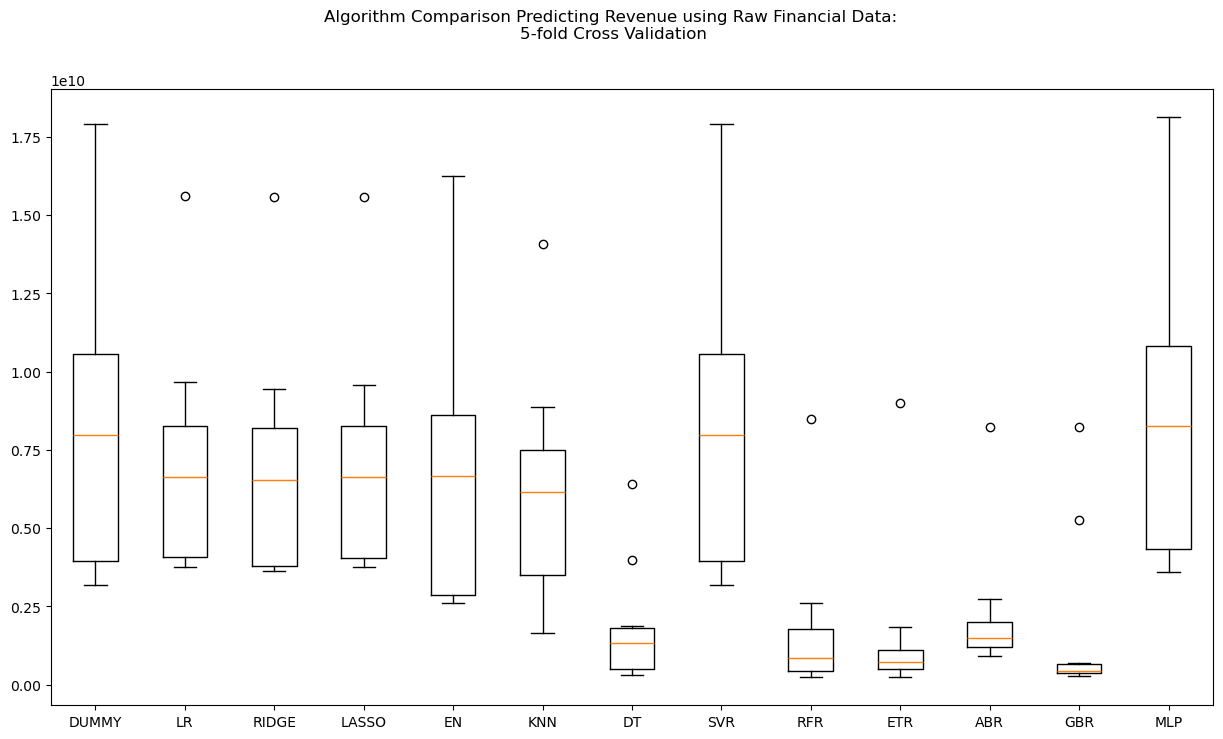

In [18]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison Predicting Revenue using Raw Financial Data: \n5-fold Cross Validation')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results_rev)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [19]:
# Let's try a better looking chart in altair
df_rev = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rev)]),
    "rmse":  np.concatenate(kfold_results_rev)
})

df_rev['rmse'] = df_rev['rmse']/1_000_000

rev_chart = alt.Chart(df_rev).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Revenue'
)



In [20]:
# Let's try a better looking chart in altair
df_ear = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_ear)]),
    "rmse":  np.concatenate(kfold_results_ear)
})

df_ear['rmse'] = df_ear['rmse']/1_000_000

ear_chart = alt.Chart(df_ear).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Net Income'
)

In [21]:
## Let's try a better looking chart in altair
#df_rat = pd.DataFrame({
#    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rat)]),
#    "rmse":  np.concatenate(kfold_results_rat)
#})
#
#df_rat['rmse'] = df_rat['rmse']
#
#rat_chart = alt.Chart(df_rat).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
#    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
#    y=alt.Y('rmse:Q', title='RMSE (% Change of Revenue)', axis = alt.Axis(grid = False)),
#    color = alt.Color('model:N', legend=None)
#).properties(
#    width=40*len(names), height=300,
#    title='QoQ Change in Revenue'
#)

In [22]:
## Let's try a better looking chart in altair
#df_marg = pd.DataFrame({
#    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_marg)]),
#    "rmse":  np.concatenate(kfold_results_marg)
#})
#
#df_rat['rmse'] = df_rat['rmse']
#
#marg_chart = alt.Chart(df_marg).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
#    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
#    y=alt.Y('rmse:Q', title='RMSE (% Change of Revenue)', axis = alt.Axis(grid = False)),
#    color = alt.Color('model:N', legend=None)
#).properties(
#    width=40*len(names), height=300,
#    title='Margin'
#)

In [23]:
full_chart = (rev_chart | ear_chart ).properties(
    title=alt.TitleParams('Raw Fundamental Feature Space', anchor='middle'))
full_chart.configure_view(stroke=None)

alt.HConcatChart(...)

## Engineered Only Data
Now that we have seen the performance of the fundamentals. Let's look at the engineered data by itself. I have a feeling this will struggle to predict the absolute revenue value because it's not included in the orginal but I may be wrong. Let's take a look.

In [ ]:
# Lets attempt this first with the raw data
X_eng = eng_data.copy()
# columns
cat_cols = ['Sector', 'Exchange', 'Market Cap'] 
num_cols = [c for c in X_eng.columns if c not in cat_cols]

# models (set seeds where applicable)
models = [
    ('DUMMY', DummyRegressor(strategy='median')),
    ('LR', LinearRegression()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('DT', DecisionTreeRegressor(random_state=random_state)),
    ('SVR', SVR()),
    ('RFR', RandomForestRegressor(random_state=random_state)),
    ('ETR', ExtraTreesRegressor(random_state=random_state)),
    ('ABR', AdaBoostRegressor(random_state=random_state)),
    ('GBR', GradientBoostingRegressor(random_state=random_state)),
    ('MLP', MLPRegressor(random_state=random_state))
]

# preprocessing
preproc = ColumnTransformer([
    ('num', Pipeline([
        ('scale', scaler)
    ]), num_cols),
    ('cat', Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols),
])

cv = KFold(n_splits=5, shuffle = True, random_state=random_state)
scorer = 'neg_root_mean_squared_error'  # RMSE as negative; flip sign after

names, kfold_results_rev, kfold_results_ear, kfold_results_rat, kfold_results_marg= [], [], [], [], []

for name, model in models:
    pipe = Pipeline([('prep', preproc), ('model', model)])
    rmse_rev = -cross_val_score(pipe, X_eng, y1_rev, cv=cv, scoring=scorer, n_jobs=-1)
    rmse_ear = -cross_val_score(pipe, X_eng, y2_ear, cv=cv, scoring=scorer, n_jobs=-1)
    
    rmse_marg = -cross_val_score(pipe, X_eng, y4_margin, cv=cv, scoring=scorer, n_jobs=-1)
    names.append(name)
    kfold_results_rev.append(rmse_rev)
    kfold_results_ear.append(rmse_ear)
    
    kfold_results_marg.append(rmse_marg)

# optional: summary
summary = pd.DataFrame({
    'model': names,
    'rev_rmse_mean': [r.mean() for r in kfold_results_rev],
    'rev_rmse_std':  [r.std()  for r in kfold_results_rev],
    'ear_rmse_mean': [r.mean() for r in kfold_results_ear],
    'ear_rmse_std':  [r.std()  for r in kfold_results_ear],
    
}).sort_values('rev_rmse_mean')
summary

,model,rev_rmse_mean,rev_rmse_std,ear_rmse_mean,ear_rmse_std
11,GBR,5.052243e+09,3.334654e+09,5.181688e+08,2.301130e+08
9,ETR,5.086717e+09,3.187731e+09,4.642843e+08,2.129700e+08
8,RFR,5.564170e+09,3.585499e+09,4.837665e+08,2.644096e+08
4,EN,6.840993e+09,4.239294e+09,6.549215e+08,2.649914e+08
2,RIDGE,7.361768e+09,3.093290e+09,6.709382e+08,2.273346e+08
5,KNN,7.722835e+09,3.792413e+09,6.513872e+08,2.477972e+08
3,LASSO,7.765242e+09,2.897279e+09,6.985447e+08,2.185944e+08
1,LR,7.831006e+09,2.865407e+09,7.028881e+08,2.182721e+08
7,SVR,8.137282e+09,4.402650e+09,7.929763e+08,2.648704e+08
0,DUMMY,8.137282e+09,4.402650e+09,7.929763e+08,2.648704e+08


In [25]:
# Let's try a better looking chart in altair
df_rev = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rev)]),
    "rmse":  np.concatenate(kfold_results_rev)
})

df_rev['rmse'] = df_rev['rmse']/1_000_000

rev_chart2 = alt.Chart(df_rev).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Revenue'
)

In [26]:
# Let's try a better looking chart in altair
df_ear = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_ear)]),
    "rmse":  np.concatenate(kfold_results_ear)
})

df_ear['rmse'] = df_ear['rmse']/1_000_000

ear_chart2 = alt.Chart(df_ear).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Net Income'
)

In [27]:
## Let's try a better looking chart in altair
#df_rat = pd.DataFrame({
#    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rat)]),
#    "rmse":  np.concatenate(kfold_results_rat)
#})
#
#df_rat['rmse'] = df_rat['rmse']
#
#rat_chart2 = alt.Chart(df_rat).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
#    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
#    y=alt.Y('rmse:Q', title='RMSE (% Change of Revenue)', axis = alt.Axis(grid = False)),
#    color = alt.Color('model:N', legend=None)
#).properties(
#    width=40*len(names), height=300,
#    title='QoQ Change in Revenue'
#)

In [28]:
## Let's try a better looking chart in altair
#df_marg = pd.DataFrame({
#    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_marg)]),
#    "rmse":  np.concatenate(kfold_results_marg)
#})
#
#df_marg['rmse'] = df_rat['rmse']
#
#marg_chart2 = alt.Chart(df_marg).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
#    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
#    y=alt.Y('rmse:Q', title='RMSE (% Change of Revenue)', axis = alt.Axis(grid = False)),
#    color = alt.Color('model:N', legend=None)
#).properties(
#    width=40*len(names), height=300,
#    title='Margin'
#)

In [29]:
full_chart2 = (rev_chart2 | ear_chart2 ).properties(
    title=alt.TitleParams('Raw Fundamental Feature Space', anchor='middle'))
full_chart2.configure_view(stroke=None)

alt.HConcatChart(...)

## Full dataset

In [ ]:
# Lets attempt this first with the raw data
X_tot = tot_data.copy()
# columns
cat_cols = ['Sector', 'Exchange', 'Market Cap'] 
num_cols = [c for c in X_tot.columns if c not in cat_cols]

# models (set seeds where applicable)
models = [
    ('DUMMY', DummyRegressor(strategy='median')),
    ('LR', LinearRegression()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('DT', DecisionTreeRegressor(random_state=random_state)),
    ('SVR', SVR()),
    ('RFR', RandomForestRegressor(random_state=random_state)),
    ('ETR', ExtraTreesRegressor(random_state=random_state)),
    ('ABR', AdaBoostRegressor(random_state=random_state)),
    ('GBR', GradientBoostingRegressor(random_state=random_state)),
    ('MLP', MLPRegressor(random_state=random_state))
]
# preprocessing
preproc = ColumnTransformer([
    ('num', Pipeline([
        ('scale', scaler)
    ]), num_cols),
    ('cat', Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols),
])

cv = KFold(n_splits=5, shuffle = True, random_state=random_state)
scorer = 'neg_root_mean_squared_error'

names, kfold_results_rev, kfold_results_ear, kfold_results_rat = [], [], [], []
kfold_mae,kfold_r2,kfold_results_marg = [],[],[]

for name, model in models:
    pipe = Pipeline([('prep', preproc), ('model', model)])
    rmse_rev = -cross_val_score(pipe, X_tot, y1_rev, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    mae_rev = -cross_val_score(pipe, X_tot, y1_rev, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    r2_rev = cross_val_score(pipe, X_tot, y1_rev, cv=cv, scoring='r2', n_jobs=-1)
    rmse_ear = -cross_val_score(pipe, X_tot, y2_ear, cv=cv, scoring=scorer, n_jobs=-1)

    rmse_marg = -cross_val_score(pipe, X_tot, y4_margin, cv=cv, scoring=scorer, n_jobs=-1)
    names.append(name)
    kfold_results_rev.append(rmse_rev)
    kfold_mae.append(mae_rev)
    kfold_r2.append(r2_rev)
    kfold_results_ear.append(rmse_ear)
    
    kfold_results_marg.append(rmse_marg)

# optional: summary
summary = pd.DataFrame({
    'model': names,
    'RMSE mean': [r.mean() for r in kfold_results_rev],
    'RMSE std':  [r.std()  for r in kfold_results_rev],
    'MAE mean': [r.mean() for r in kfold_mae],
    'MAE std':  [r.std()  for r in kfold_mae],
    'r2 mean': [r.mean() for r in kfold_r2],
    'r2 std': [r.std() for r in kfold_r2],
})
summary.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
model,DUMMY,LR,RIDGE,LASSO,EN,KNN,DT,SVR,RFR,ETR,ABR,GBR,MLP
RMSE mean,8137282480.989322,7611442840.126925,6818903917.233094,7460256167.793844,6618570494.837899,7035334279.137505,3776937159.308019,8137282456.102277,2256363435.94645,1811440384.902811,2484034309.563928,1872594340.047145,8432790869.388517
RMSE std,4402649833.80627,2370727189.322606,2790815064.273232,2360861812.163906,4020229958.737335,3807653361.573247,4046320217.626839,4402649839.316028,2564767657.885953,2421134301.364258,2502904700.312794,2751442388.76928,4345936271.647674
MAE mean,2750118248.594821,4767114600.105425,3955293993.61518,4668193326.443903,2759988498.712957,1833378428.236651,681467907.40733,2750118210.633635,420963883.824092,392699317.181966,1162139800.620253,379031968.600764,3088258700.89309
MAE std,925091983.311718,357900599.032511,501741064.957496,376397754.768845,707421725.882491,706320717.629326,532472557.02646,925091982.660798,338804292.102124,330772967.249822,359123832.130632,345370517.631551,953908462.525144
r2 mean,-0.104713,-0.636046,-0.097598,-0.54684,0.309948,0.115643,0.706817,-0.104713,0.932597,0.94341,0.891331,0.93727,-0.233309
r2 std,0.046827,1.34577,0.69368,1.229056,0.105169,0.310146,0.490285,0.046826,0.0797,0.076435,0.086941,0.102742,0.142312


In [31]:
summary = pd.DataFrame({
    'model': names,
    'RMSE mean': [str(int(r.mean()/1_000_000))+'M' for r in kfold_results_rev],
    'RMSE std':  [str(int(r.std()/1_000_000))+'M'  for r in kfold_results_rev],
    'MAE mean': [str(int(r.mean()/1_000_000))+'M' for r in kfold_mae],
    'MAE std':  [str(int(r.std()/1_000_000))+'M'  for r in kfold_mae],
    'r2 mean': [np.round(r.mean(),3) for r in kfold_r2],
    'r2 std': [np.round(r.std(),3) for r in kfold_r2],
})
summary.set_index('model')

,RMSE mean,RMSE std,MAE mean,MAE std,r2 mean,r2 std
model,,,,,,
DUMMY,8137M,4402M,2750M,925M,-0.105,0.047
LR,7611M,2370M,4767M,357M,-0.636,1.346
RIDGE,6818M,2790M,3955M,501M,-0.098,0.694
LASSO,7460M,2360M,4668M,376M,-0.547,1.229
EN,6618M,4020M,2759M,707M,0.310,0.105
KNN,7035M,3807M,1833M,706M,0.116,0.310
DT,3776M,4046M,681M,532M,0.707,0.490
SVR,8137M,4402M,2750M,925M,-0.105,0.047
RFR,2256M,2564M,420M,338M,0.933,0.080


In [32]:
# Let's try a better looking chart in altair
df_rev = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rev)]),
    "rmse":  np.concatenate(kfold_results_rev)
})

df_rev['rmse'] = df_rev['rmse']/1_000_000

rev_chart3 = alt.Chart(df_rev).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Revenue'
)

In [33]:
# Let's try a better looking chart in altair
df_ear = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_ear)]),
    "rmse":  np.concatenate(kfold_results_ear)
})

df_ear['rmse'] = df_ear['rmse']/1_000_000

ear_chart3 = alt.Chart(df_ear).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Net Income'
)

In [34]:
## Let's try a better looking chart in altair
#df_rat = pd.DataFrame({
#    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rat)]),
#    "rmse":  np.concatenate(kfold_results_rat)
#})
#
#df_rat['rmse'] = df_rat['rmse']
#
#rat_chart3 = alt.Chart(df_rat).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
#    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
#    y=alt.Y('rmse:Q', title='RMSE (% Change of Revenue)', axis = alt.Axis(grid = False)),
#    color = alt.Color('model:N', legend=None)
#).properties(
#    width=40*len(names), height=300,
#    title='QoQ Change in Revenue'
#)

In [35]:
## Let's try a better looking chart in altair
#df_marg = pd.DataFrame({
#    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_marg)]),
#    "rmse":  np.concatenate(kfold_results_marg)
#})
#
#df_rat['rmse'] = df_rat['rmse']
#
#marg_chart3 = alt.Chart(df_marg).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
#    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
#    y=alt.Y('rmse:Q', title='RMSE (% Change of Revenue)', axis = alt.Axis(grid = False)),
#    color = alt.Color('model:N', legend=None)
#).properties(
#    width=40*len(names), height=300,
#    title='Margin'
#)

In [36]:
full_chart3 = (rev_chart3 | ear_chart3 ).properties(
    title=alt.TitleParams('Regression Model Evaluation using Root Mean Squared Error: 5-fold Cross-Validation', fontSize = 20, anchor='middle'))
full_chart3.configure_view(stroke=None)

alt.HConcatChart(...)

In [37]:
(full_chart & full_chart2 & full_chart3).configure_view(stroke=None).properties(
    title=alt.TitleParams('RMSE Comparing Feature Space and Predictor Variables Without Mega- and Micro-Cap using 5-Fold Cross Validation', anchor='middle'))

alt.VConcatChart(...)

## PCA Only Data

In [ ]:
# Lets attempt this first with the raw data
X_pca = pca_data.copy()
# columns
#cat_cols = ['Sector', 'Exchange', 'Market Cap'] 
num_cols = X_pca.columns

# models (set seeds where applicable)
models = [
    ('DUMMY', DummyRegressor(strategy='mean')),
    ('LR', LinearRegression()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('DT', DecisionTreeRegressor(random_state=random_state)),
    ('SVR', SVR()),
    ('RFR', RandomForestRegressor(random_state=random_state)),
    ('ETR', ExtraTreesRegressor(random_state=random_state)),
    ('ABR', AdaBoostRegressor(random_state=random_state)),
    ('GBR', GradientBoostingRegressor(random_state=random_state)),
]

# preprocessing
preproc = ColumnTransformer([
    ('num', Pipeline([
        ('scale', scaler)
    ]), num_cols),
    
])

cv = KFold(n_splits=5, shuffle = True, random_state=random_state)
scorer = 'neg_root_mean_squared_error'  # RMSE as negative; flip sign after

names, kfold_results_rev, kfold_results_ear = [], [], []

for name, model in models:
    pipe = Pipeline([('prep', preproc), ('model', model)])
    rmse_rev = -cross_val_score(pipe, X_pca, y1_rev, cv=cv, scoring=scorer, n_jobs=-1)
    rmse_ear = -cross_val_score(pipe, X_pca, y2_ear, cv=cv, scoring=scorer, n_jobs=-1)
    names.append(name)
    kfold_results_rev.append(rmse_rev)
    kfold_results_ear.append(rmse_ear)

# optional: summary
summary = pd.DataFrame({
    'model': names,
    'rev_rmse_mean': [r.mean() for r in kfold_results_rev],
    'rev_rmse_std':  [r.std()  for r in kfold_results_rev],
    'ear_rmse_mean': [r.mean() for r in kfold_results_ear],
    'ear_rmse_std':  [r.std()  for r in kfold_results_ear],
}).sort_values('rev_rmse_mean')
summary

,model,rev_rmse_mean,rev_rmse_std,ear_rmse_mean,ear_rmse_std
9,ETR,6.798269e+09,3.420302e+09,5.024250e+08,2.393286e+08
8,RFR,6.806253e+09,3.495987e+09,5.230991e+08,2.437153e+08
11,GBR,6.969018e+09,3.506343e+09,5.459258e+08,2.407907e+08
2,RIDGE,7.190291e+09,3.697614e+09,6.822314e+08,2.418061e+08
3,LASSO,7.200265e+09,3.686577e+09,6.828085e+08,2.413516e+08
1,LR,7.244505e+09,3.646053e+09,6.860268e+08,2.406849e+08
4,EN,7.376098e+09,4.337243e+09,7.202338e+08,2.636002e+08
0,DUMMY,7.893196e+09,4.287251e+09,7.698440e+08,2.576405e+08
7,SVR,8.137282e+09,4.402650e+09,7.929763e+08,2.648704e+08
5,KNN,8.225357e+09,3.639026e+09,7.064450e+08,2.382895e+08


In [39]:
# Let's try a better looking chart in altair
df_rev = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_rev)]),
    "rmse":  np.concatenate(kfold_results_rev)
})

df_rev['rmse'] = df_rev['rmse']/1_000_000

rev_chart4 = alt.Chart(df_rev).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Revenue'
)

In [40]:
# Let's try a better looking chart in altair
df_ear = pd.DataFrame({
    "model": np.concatenate([[n]*len(v) for n, v in zip(names, kfold_results_ear)]),
    "rmse":  np.concatenate(kfold_results_ear)
})

df_ear['rmse'] = df_ear['rmse']/1_000_000

ear_chart4 = alt.Chart(df_ear).mark_boxplot(size=33, opacity=0.5, median={'color': 'black', 'strokeWidth': 3}).encode(
    x=alt.X('model:N', sort=names, title='Regression Model', axis = alt.Axis(labelAngle = 0, grid = False)),
    y=alt.Y('rmse:Q', title='RMSE (millions of $)', axis = alt.Axis(grid = False)),
    color = alt.Color('model:N', legend=None)
).properties(
    width=40*len(names), height=300,
    title='Net Income'
)

In [41]:
full_chart4 = (rev_chart4 | ear_chart4).properties(
    title=alt.TitleParams('Full Feature Space', anchor='middle'))
full_chart4.configure_view(stroke=None)

alt.HConcatChart(...)